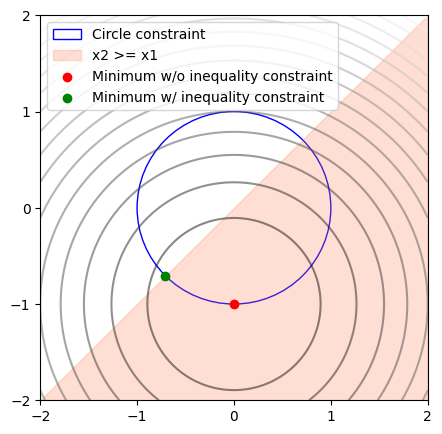

In [1]:
import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optimistix as optx


def objective(y, args):
    del args
    x1, x2 = y
    return x1**2 + (x2 + 1) ** 2  # Minimize the sum of squares


def constraint(y):
    x1, x2 = y
    c1 = x1**2 + x2**2 - 1  # Circle constraint
    c2 = x2 - x1  # x2 >= 1
    return c1, c2


fig, ax = plt.subplots(1, 1, figsize=(5, 5))

x = jnp.linspace(-2, 2, 100)
y = jnp.linspace(-2, 2, 100)
X, Y = jnp.meshgrid(x, y)


def wrapped_objective(y):
    return objective(y, None)


Z = wrapped_objective((X, Y))

ax.contour(X, Y, Z, levels=20, alpha=0.5, cmap="Grays_r")

circle = plt.Circle((0, 0), 1, color="blue", fill=False, label="Circle constraint")
ax.add_patch(circle)

labels = [-2, -1, 0, 1, 2]
ax.set_xticks(labels)
ax.set_yticks(labels)

ax.fill_between(x, x, -2, color="coral", alpha=0.25, label="x2 >= x1")

ax.scatter(0, -1, color="red", label="Minimum w/o inequality constraint")
ax.scatter(-0.707, -0.707, color="green", label="Minimum w/ inequality constraint")
ax.legend()

In [9]:
solver = optx.IPOPTLike(rtol=1e-2, atol=1e-4)
descent = optx.XDYcYdDescent()
solver = eqx.tree_at(lambda x: x.descent, solver, descent)


solution = optx.minimise(
    objective,
    solver,
    jnp.array([-0.1, -0.0]),  # Start from inequality constrained optimum
    constraint=constraint,
    max_steps=25,
    throw=False,
)

solution.value

iterate in init: (Array([-0.1, -0. ], dtype=float32), (Array(1., dtype=float32), Array(1., dtype=float32)), (Array([0., 0.], dtype=float32), Array([0., 0.], dtype=float32)))
iterate in step: (Array([-0.1, -0. ], dtype=float32), (Array(1., dtype=float32), Array(1., dtype=float32)), (Array([0., 0.], dtype=float32), Array([0., 0.], dtype=float32)))
iterate in step: (Array([-5.0499997, -5.1400027], dtype=float32), (Array(11.000017, dtype=float32), Array(-4.2915344e-06, dtype=float32)), (Array([0., 0.], dtype=float32), Array([0., 0.], dtype=float32)))
iterate in step: (Array([-2.5749998, -2.5700014], dtype=float32), (Array(16.000027, dtype=float32), Array(-0.50000644, dtype=float32)), (Array([0., 0.], dtype=float32), Array([0., 0.], dtype=float32)))
iterate in step: (Array([-1.3375   , -1.2850007], dtype=float32), (Array(18.50003, dtype=float32), Array(-0.7500075, dtype=float32)), (Array([0., 0.], dtype=float32), Array([0., 0.], dtype=float32)))
iterate in step: (Array([-0.71875   , -0.6425

Array([-0.7479136, -0.6637963], dtype=float32)

We seem to converge to a "wrong spot" - perhaps to be expected with a hard-coded, nonadaptive barrier parameter.

In [3]:
jnp.stack(jnp.eye(2)).shape

(2, 2)

In [4]:
# https://github.com/Tim-Salzmann/l4casadi/blob/main/examples/fish_turbulent_flow/README.md